In [1]:
import os
import requests
import glob

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # для qq plot

from scipy.stats import shapiro 
from scipy.stats import normaltest 
from scipy.stats import mannwhitneyu 
from scipy.stats import ttest_ind 
from statsmodels.stats.weightstats import ztest 
from scipy.stats import kruskal 
from scipy import stats 
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("asset-v1 SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv")
data.head()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891,185,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891,209,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891,254,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891,156,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891,194,elder_group


In [3]:
data.shape
data.columns

Index(['distance_to_vasculature', 'distance_to_largest_cell',
       'immune_marker_1', 'immune_marker_2', 'cell_interaction', 'cell_type',
       'case_id', 'area_of_cell', 'age_group'],
      dtype='object')

In [4]:
missing_values = data.isnull().sum()
print("Количество пропусков в столбцах:", missing_values)
num_duplicates = data.duplicated().sum()
print("Количество явных дубликатов:", num_duplicates) 

Количество пропусков в столбцах: distance_to_vasculature     0
distance_to_largest_cell    0
immune_marker_1             0
immune_marker_2             0
cell_interaction            0
cell_type                   0
case_id                     0
area_of_cell                0
age_group                   0
dtype: int64
Количество явных дубликатов: 0


#### задача 1а
 есть ли стат-значимость между типом клетки и размером клетки (area_of_cell), добавьте hue по возрастным группам.

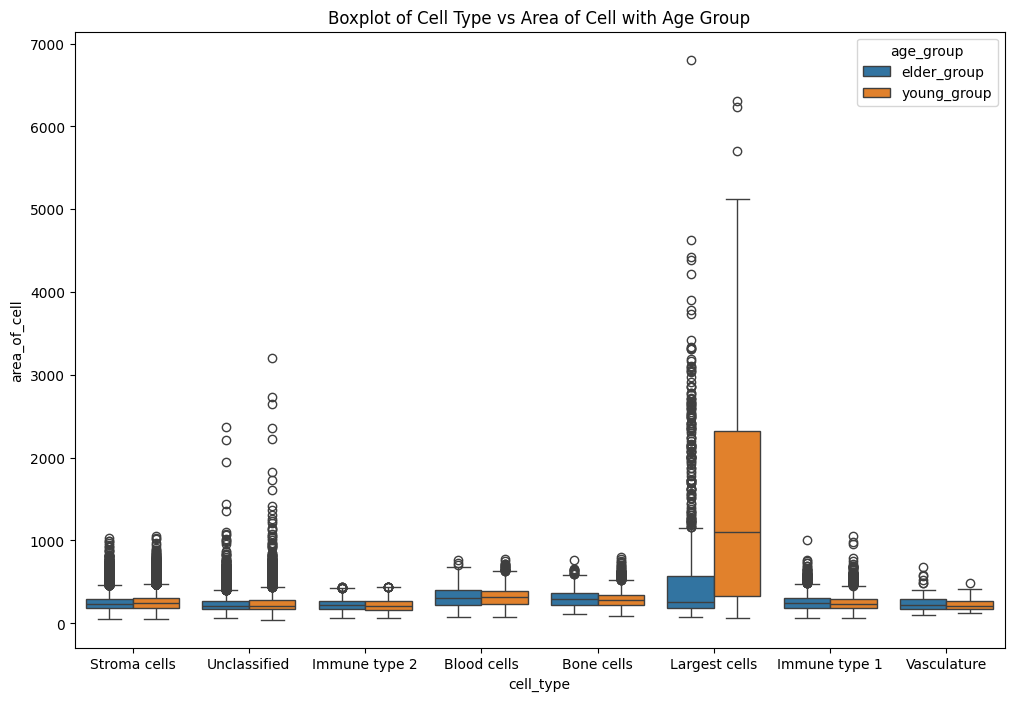

In [5]:
# определяем размер графика
plt.figure(figsize=(12, 8))

# строим диаграмму размаха для 'cell_type' и 'area_of_cell' с разделением по 'age_group'
sns.boxplot(x='cell_type', y='area_of_cell', data=data, hue='age_group')
plt.title('Boxplot of Cell Type vs Area of Cell with Age Group')
plt.show()

визуально нет больших различий в данных, кроме группы largest cells

In [6]:
# просмотр описательных статистик датасета.

agg_func_math = {'area_of_cell': ['count', 'sum', 'mean', 'median', 'min', 'max', 'std', 'var', 'describe']}
data.groupby(['cell_type', 'age_group']).agg(agg_func_math).round(2)

area_of_cell                                         \
                                 count          sum         mean       median   
                          area_of_cell area_of_cell area_of_cell area_of_cell   
cell_type     age_group                                                         
Blood cells   elder_group          521       170962       328.14        304.0   
              young_group         2297       749475       326.28        313.0   
Bone cells    elder_group          391       120632       308.52        293.0   
              young_group         2164       628382       290.38        276.0   
Immune type 1 elder_group         1583       404738       255.68        240.0   
              young_group         3992       977293       244.81        229.0   
Immune type 2 elder_group         7557      1720414       227.66        220.0   
              young_group         8647      1915580       221.53        206.0   
Largest cells elder_group          879       539431       613.69        263.0   
              young_group         1109      1619630      1460.44       1099.0   
Stroma cells  elder_group        45784     11207070       244.78        229.0   
              young_group       127408     32432433       254.56        240.0   
Unclassified  elder_group        23735      5361626       225.90        210.0   
              young_group        43231     10175857       235.38        214.0   
Vasculature   elder_group           92        22511       244.68        217.0   
              young_group           52        12021       231.17        210.0   

                                                                               \
                                   min          max          std          var   
                          area_of_cell area_of_cell area_of_cell area_of_cell   
cell_type     age_group                                                         
Blood cells   elder_group           79          766       134.96     18215.35   
              young_group           72          782       123.73     15309.08   
Bone cells    elder_group          107          762       114.84     13188.26   
              young_group           90          803       104.94     11012.61   
Immune type 1 elder_group           63         1005       103.62     10736.91   
              young_group           63         1052        94.41      8913.14   
Immune type 2 elder_group           59          439        69.37      4812.86   
              young_group           65          441        75.84      5751.60   
Largest cells elder_group           79         6807       806.57    650559.07   
              young_group           62         6311      1234.88   1524938.41   
Stroma cells  elder_group           57         1035        94.68      8964.83   
              young_group           52         1055        93.80      8797.65   
Unclassified  elder_group           59         2371        89.41      7993.42   
              young_group           45         3200       102.66     10539.49   
Vasculature   elder_group           96          674       108.45     11761.84   
              young_group          125          487        77.10      5944.46   

                                                                              \
                           describe                                            
                              count     mean      std    min     25%     50%   
cell_type     age_group                                                        
Blood cells   elder_group     521.0   328.14   134.96   79.0  218.00   304.0   
              young_group    2297.0   326.28   123.73   72.0  237.00   313.0   
Bone cells    elder_group     391.0   308.52   114.84  107.0  224.00   293.0   
              young_group    2164.0   290.38   104.94   90.0  217.00   276.0   
Immune type 1 elder_group    1583.0   255.68   103.62   63.0  185.00   240.0   
              young_group    3992.0   244.81    94.41   63.0  18

In [7]:
# проводим тест Шапиро-Уилка для каждой комбинации 'cell_type' и 'age_group'
for (cell_type, age_group), group_data in data.groupby(['cell_type', 'age_group']):
    _, p_value = shapiro(group_data['area_of_cell'])
    print(f"Cell Type: {cell_type}, Age Group: {age_group}, Shapiro-Wilk p-value: {p_value}")

Cell Type: Blood cells, Age Group: elder_group, Shapiro-Wilk p-value: 5.183330986646695e-10
Cell Type: Blood cells, Age Group: young_group, Shapiro-Wilk p-value: 2.1042767963977946e-21
Cell Type: Bone cells, Age Group: elder_group, Shapiro-Wilk p-value: 1.2447218256106396e-10
Cell Type: Bone cells, Age Group: young_group, Shapiro-Wilk p-value: 8.514108968429559e-30
Cell Type: Immune type 1, Age Group: elder_group, Shapiro-Wilk p-value: 1.4941454786522319e-30
Cell Type: Immune type 1, Age Group: young_group, Shapiro-Wilk p-value: 1.401298464324817e-45
Cell Type: Immune type 2, Age Group: elder_group, Shapiro-Wilk p-value: 1.766961760847569e-27
Cell Type: Immune type 2, Age Group: young_group, Shapiro-Wilk p-value: 1.1210387714598537e-44
Cell Type: Largest cells, Age Group: elder_group, Shapiro-Wilk p-value: 3.8383526755706794e-40
Cell Type: Largest cells, Age Group: young_group, Shapiro-Wilk p-value: 1.3339217284187455e-26
Cell Type: Stroma cells, Age Group: elder_group, Shapiro-Wilk p-

применение теста Шапиро показало, что распределение по cell_type в различных возрастных группах не является нормальным, p_value значительно ниже 0,05 и Н0 отклоняем.  Для ответа на вопрос есть ли стат-значимость между типом клетки(cell_type) и размером клетки (area_of_cell) воспользуемся критерием Краскела_Уоллиса, непараметрический критерий который используется для анализа трех и более независимых выборок.

In [8]:
# создание подвыборок для каждой из возрастных групп
elder_group_data = data[data['age_group'] == 'elder_group']['area_of_cell']
young_group_data = data[data['age_group'] == 'young_group']['area_of_cell']

# проведение теста Краскела-Уоллиса
statistic, p_value = kruskal(elder_group_data, young_group_data)

print("Статистика теста:", statistic)
print("p-значение:", p_value)

Статистика теста: 805.8122038798942
p-значение: 2.940282459254406e-177


p-value > 0,05 показывает что статистически значимых отличий между анализируемыми группами нет.

#### задача 1b
Есть ли стат-значимость между типом клетки и экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

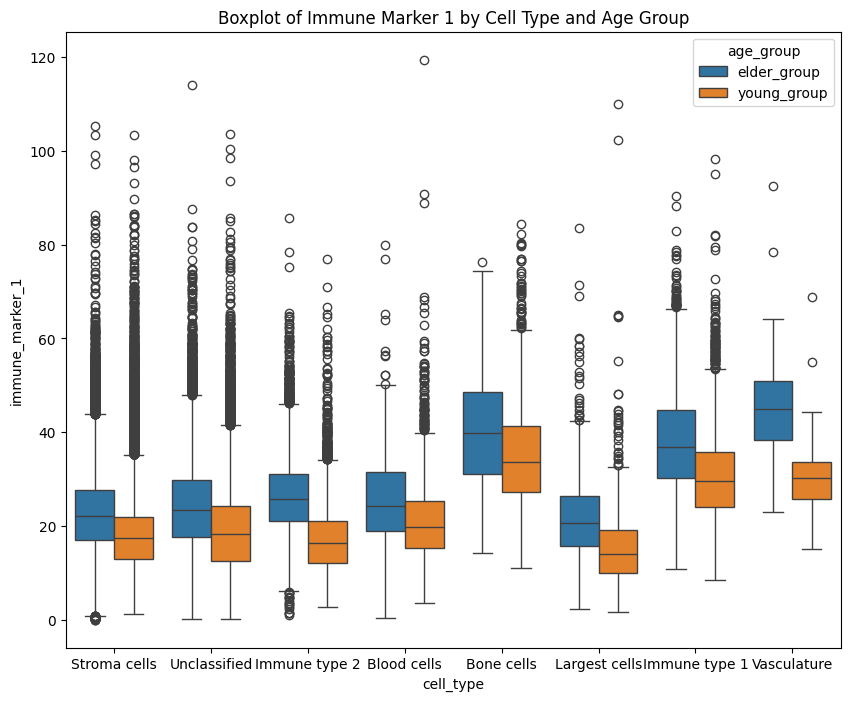

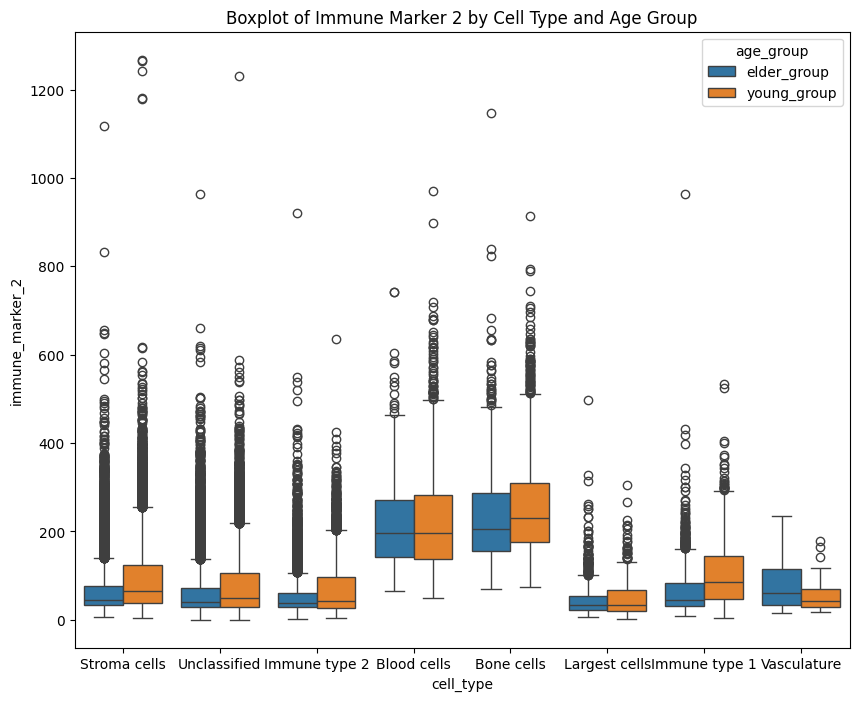

In [9]:
# создание boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x="cell_type", y="immune_marker_1", hue="age_group", data=data)
plt.title("Boxplot of Immune Marker 1 by Cell Type and Age Group")
plt.show()

plt.figure(figsize=(10, 8))
sns.boxplot(x="cell_type", y="immune_marker_2", hue="age_group", data=data)
plt.title("Boxplot of Immune Marker 2 by Cell Type and Age Group")
plt.show()

визуально можно сказать, что данные довольно гетерогенны, иммунный маркеры значительно отличаются по экспрессии, и попарно есть отличия в экспрессии иммунных маркеров по возрасту и по типу клеток. 

In [10]:
# проверяем нормальность распределения экспрессии иммунного маркера для каждой группы
for cell_type in data['cell_type'].unique():
    # выделяем данные по конкретному типу клетки
    group_data = data[data['cell_type'] == cell_type]['immune_marker_1']
    statistic, p_value = stats.shapiro(group_data)
    print(f"Cell Type: {cell_type}, Shapiro-Wilk Test [Statistic: {statistic:.2f}, p-value: {p_value:.4f}]")

Cell Type: Stroma cells, Shapiro-Wilk Test [Statistic: 0.96, p-value: 0.0000]
Cell Type: Unclassified, Shapiro-Wilk Test [Statistic: 0.97, p-value: 0.0000]
Cell Type: Immune type 2, Shapiro-Wilk Test [Statistic: 0.97, p-value: 0.0000]
Cell Type: Blood cells, Shapiro-Wilk Test [Statistic: 0.90, p-value: 0.0000]
Cell Type: Bone cells, Shapiro-Wilk Test [Statistic: 0.97, p-value: 0.0000]
Cell Type: Largest cells, Shapiro-Wilk Test [Statistic: 0.88, p-value: 0.0000]
Cell Type: Immune type 1, Shapiro-Wilk Test [Statistic: 0.96, p-value: 0.0000]
Cell Type: Vasculature, Shapiro-Wilk Test [Statistic: 0.97, p-value: 0.0012]


In [11]:
# проверяем нормальность распределения экспрессии иммунного маркера для каждой группы
for cell_type in data['cell_type'].unique():
    # выделяем данные по конкретному типу клетки
    group_data = data[data['cell_type'] == cell_type]['immune_marker_2']
    statistic, p_value = stats.shapiro(group_data)
    print(f"Cell Type: {cell_type}, Shapiro-Wilk Test [Statistic: {statistic:.2f}, p-value: {p_value:.4f}]")

Cell Type: Stroma cells, Shapiro-Wilk Test [Statistic: 0.87, p-value: 0.0000]
Cell Type: Unclassified, Shapiro-Wilk Test [Statistic: 0.80, p-value: 0.0000]
Cell Type: Immune type 2, Shapiro-Wilk Test [Statistic: 0.76, p-value: 0.0000]
Cell Type: Blood cells, Shapiro-Wilk Test [Statistic: 0.91, p-value: 0.0000]
Cell Type: Bone cells, Shapiro-Wilk Test [Statistic: 0.90, p-value: 0.0000]
Cell Type: Largest cells, Shapiro-Wilk Test [Statistic: 0.77, p-value: 0.0000]
Cell Type: Immune type 1, Shapiro-Wilk Test [Statistic: 0.88, p-value: 0.0000]
Cell Type: Vasculature, Shapiro-Wilk Test [Statistic: 0.86, p-value: 0.0000]


Здесь так же тест Шапиро показал, что распределение по cell_type в различных возрастных группах  и экспрессией иммунных маркеров (immune_marker_1, immune_marker_2) не является нормальным, Н0 - отклоняется.  Для ответа на вопрос есть ли стат-значимость между типом клетки(cell_type) и экспрессией иммунных маркеров (immune_marker_1, immune_marker_2)  так же воспользуемся критерием Краскела_Уоллиса. 

In [12]:
# проводим тест Краскела-Уоллиса для immune_marker_1 и immune_marker_2
result1 = kruskal(*[data[data['cell_type'] == cell_type]['immune_marker_1']
                  for cell_type in data['cell_type'].unique()])
result2 = kruskal(*[data[data['cell_type'] == cell_type]['immune_marker_2']
                  for cell_type in data['cell_type'].unique()])

print("P-value для immune_marker_1: ", result1.pvalue)
print("P-value для immune_marker_2: ", result2.pvalue)

P-value для immune_marker_1:  0.0
P-value для immune_marker_2:  0.0


In [13]:
# проводим тест Краскела-Уоллиса с учетом возрастных групп для immune_marker_1
result1 = kruskal(*[data[(data['cell_type'] == cell_type) & (data['age_group'] == age_group)]['immune_marker_1']
                    for cell_type in data['cell_type'].unique()
                    for age_group in data['age_group'].unique()])

# проводим тест Краскела-Уоллиса с учетом возрастных групп для immune_marker_2
result2 = kruskal(*[data[(data['cell_type'] == cell_type) & (data['age_group'] == age_group)]['immune_marker_2']
                    for cell_type in data['cell_type'].unique()
                    for age_group in data['age_group'].unique()])

print("P-value для immune_marker_1 с учетом возрастных групп: ", result1.pvalue)
print("P-value для immune_marker_2 с учетом возрастных групп: ", result2.pvalue)

P-value для immune_marker_1 с учетом возрастных групп:  0.0
P-value для immune_marker_2 с учетом возрастных групп:  0.0


P-значения около 0, указывают на статистически значимые различия в распределениях маркеров иммунитета по возрастным группам и типам клеток.

#### задача 1в
Есть ли стат-значимость между типом клетки и Дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.

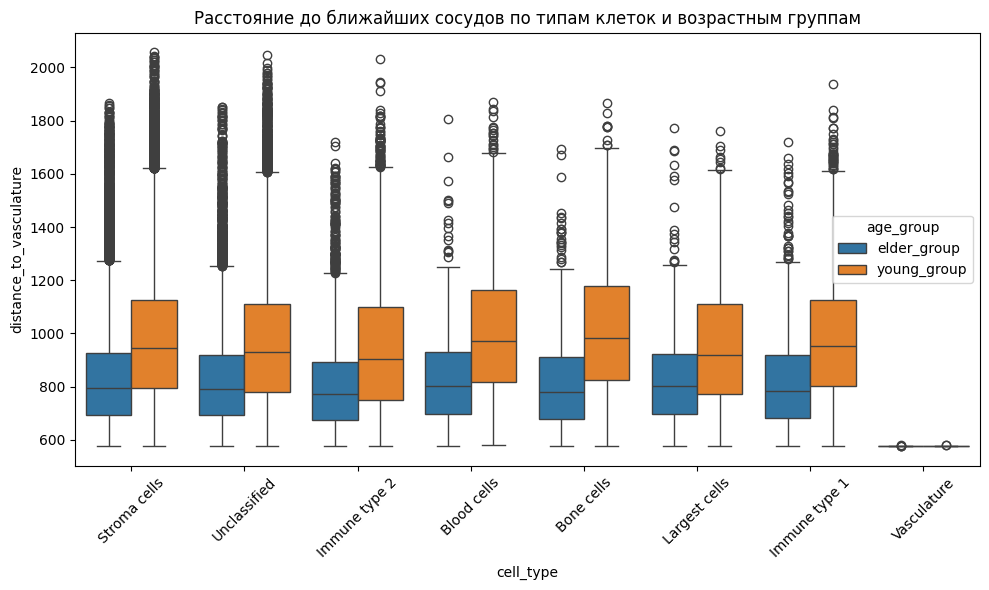

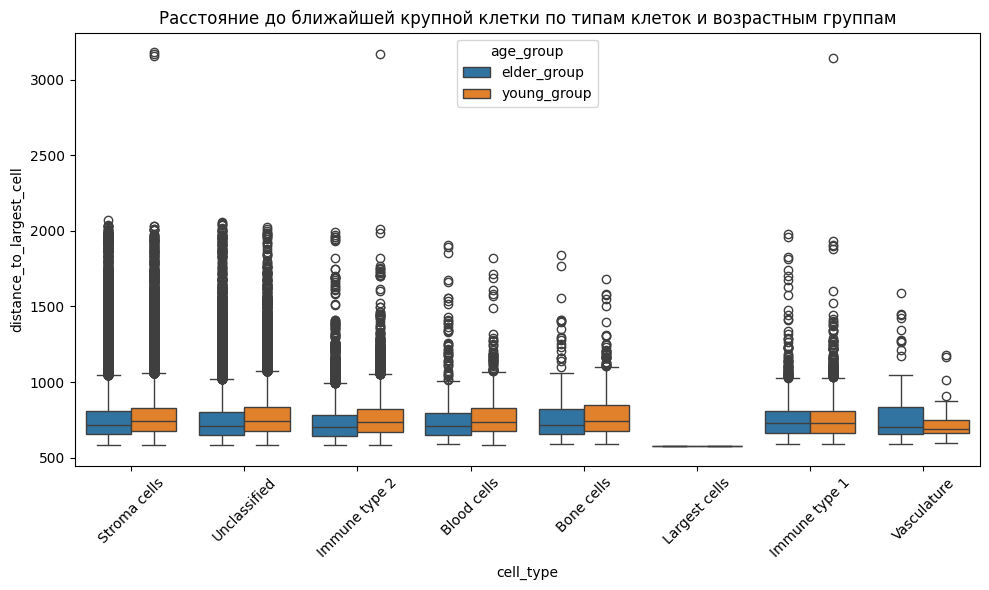

In [14]:
# визуализация для 'distance_to_vasculature'
plt.figure(figsize=(10, 6))
sns.boxplot(x='cell_type', y='distance_to_vasculature', hue='age_group', data=data)
plt.title('Расстояние до ближайших сосудов по типам клеток и возрастным группам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# визуализация для 'distance_to_largest_cell'
plt.figure(figsize=(10, 6))
sns.boxplot(x='cell_type', y='distance_to_largest_cell',hue='age_group', data=data)
plt.title('Расстояние до ближайшей крупной клетки по типам клеток и возрастным группам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Распределение расстояний до ближайших сосудов явно отличается по возрастным группам, по типу клеток визуально отличия не прослеживаются. В отношении расстояния  до ближайшей крупной клетки для разных типов клеток, а также в зависимости от возрастной группы визуально отличия не наблюдаются.

In [15]:
# построение модели и выполнение ANOVA для 'distance_to_vasculature'
model_vasculature = ols('distance_to_vasculature ~ C(cell_type) + C(age_group) + C(cell_type):C(age_group)', data=data).fit()
anova_results_vasculature = sm.stats.anova_lm(
    model_vasculature, typ=2)  # typ=2 для многофакторного ANOVA
print("Результаты ANOVA для distance_to_vasculature:\n", anova_results_vasculature)

# построение модели и выполнение ANOVA для 'distance_to_largest_cell'
model_largest_cell = ols('distance_to_largest_cell ~ C(cell_type) + C(age_group) + C(cell_type):C(age_group)', data=data).fit()
anova_results_largest_cell = sm.stats.anova_lm(
    model_largest_cell, typ=2)  # typ=2 для многофакторного ANOVA
print("\nРезультаты ANOVA для distance_to_largest_cell:\n", anova_results_largest_cell)

Результаты ANOVA для distance_to_vasculature:
                                  sum_sq        df             F         PR(>F)
C(cell_type)               3.888428e+07       7.0    113.193547  1.470817e-166
C(age_group)               1.170481e+09       1.0  23851.191534   0.000000e+00
C(cell_type):C(age_group)  2.200946e+06       7.0      6.407033   1.465087e-07
Residual                   1.322190e+10  269426.0           NaN            NaN

Результаты ANOVA для distance_to_largest_cell:
                                  sum_sq        df           F        PR(>F)
C(cell_type)               7.198732e+07       7.0  507.079430  0.000000e+00
C(age_group)               8.721426e+06       1.0  430.036712  1.895345e-95
C(cell_type):C(age_group)  3.441322e+06       7.0   24.240711  2.999812e-33
Residual                   5.464135e+09  269426.0         NaN           NaN


  Тест ANOVA для анализа расстояния до ближайших сосудов дал PR(>F) (p-значение) сильно меньше 0.05 и получается что: говорит о статистически значимом влиянии типа клетки на расстояние до сосудов; что указывает на статистически значимое влияние возрастной группы на расстояние до сосудов. p-значение (1.465087e-07), тоже статистически значимо и указывает на то что есть взаимодействие/связь между типом клетки и возрастной группой при определении расстояния до сосудов .
 Тест ANOVA для анализа расстояния до ближайшей крупной клетки так же показал что есть связь между типом клетки на расстоянием до ближайшей крупной клетки, есть влияние возраста и между тремя этими параметрами.    
 У теста ANOVA есть ограничения: нормальность распределения и гомоскедастичность. Сделаем проверку на нормальность остатков моделей, и тест  


In [16]:
# Проверка нормальности остатков для модели 'distance_to_vasculature'
residuals_vasculature = model_vasculature.resid
shapiro_test_vasculature = stats.shapiro(residuals_vasculature)
print("Тест Шапиро-Уилка для остатков модели 'distance_to_vasculature':\n",
      shapiro_test_vasculature)

# Проверка нормальности остатков для модели 'distance_to_largest_cell'
residuals_largest_cell = model_largest_cell.resid
shapiro_test_largest_cell = stats.shapiro(residuals_largest_cell)
print("\nТест Шапиро-Уилка для остатков модели 'distance_to_largest_cell':\n",
      shapiro_test_largest_cell)

Тест Шапиро-Уилка для остатков модели 'distance_to_vasculature':
 ShapiroResult(statistic=0.9617070555686951, pvalue=0.0)

Тест Шапиро-Уилка для остатков модели 'distance_to_largest_cell':
 ShapiroResult(statistic=0.8248610496520996, pvalue=0.0)


Тест Шапиро показывает что распределение не является нормальным.

In [17]:
# Группировка данных по комбинациям факторов
grouped_data = data.groupby(['cell_type', 'age_group'])

# Получение остатков от ANOVA для каждой группы
residuals_by_group = [group['distance_to_vasculature'] -
                      model_vasculature.predict(group) for name, group in grouped_data]

# Преобразование в соответствующий формат для теста Левена
flattened_residuals = np.concatenate(residuals_by_group)
group_labels = [name for name,
                group in grouped_data for _ in range(len(group))]

# Тест Левена
levene_test = stats.levene(*residuals_by_group, center='mean')
print(
    f"Levene test for equal variances: statistic={levene_test.statistic}, p-value={levene_test.pvalue}")

Levene test for equal variances: statistic=633.0954575300134, p-value=0.0


Результат теста Левена показывает, что дисперсии в группах статистически значимо отличаются друг от друга, и гомоскедастичности здесь нет, учитывая что распределение так же не нормальное, применение ANOVA теста не коректно.


Вывод.  Применить статистические методы ANOVA в данном случае не корректно, ограничиваюсь визуальной оценкой.
Распределение расстояний до ближайших сосудов явно отличается по возрастным группам, в группе молодых пациентов оно больше чем в руппе пожилых пациентов; по типу клеток визуально отличия не прослеживаются. В отношении расстояния  до ближайшей крупной клетки для разных типов клеток, а также в зависимости от возрастной группы визуально отличия не наблюдаются.

#
#





### задача 2


В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:  по Ох будут типы клеток, по Оу — их количество.  Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [18]:
# группировка данных по пациентам и типам клеток и подсчет количества клеток каждого типа
cell_counts = data.groupby(['case_id', 'cell_type']).agg({
    'distance_to_vasculature': 'mean',  # среднее расстояние до сосудов
    'distance_to_largest_cell': 'mean',  # среднее расстояние до крупной клетки
    'immune_marker_1': 'mean',  # среднее значение экспрессии иммунного маркера 1
    'immune_marker_2': 'mean',  # среднее значение экспрессии иммунного маркера 2
    'area_of_cell': 'mean',  # средний размер клетки
    # первое значение столбца cell_interaction для каждой группы
    'cell_interaction': 'first'
}).reset_index()

# добавление колонки cell_count
cell_counts['cell_count'] = data.groupby(['case_id', 'cell_type']).size().values

# вывод полученного датасета
print(cell_counts)

    case_id      cell_type  distance_to_vasculature  distance_to_largest_cell  \
0        40    Blood cells               811.482715                728.139247   
1        40     Bone cells               790.574645                740.268561   
2        40  Immune type 1               811.511720                750.089165   
3        40  Immune type 2               795.311464                729.372655   
4        40  Largest cells               822.114561                576.499492   
..      ...            ...                      ...                       ...   
59      983  Immune type 2               896.667593                769.028528   
60      983  Largest cells               941.766273                576.471227   
61      983   Stroma cells               921.886236                760.222782   
62      983   Unclassified               915.023758                764.158297   
63      983    Vasculature               576.405395                840.446021   

    immune_marker_1  immune

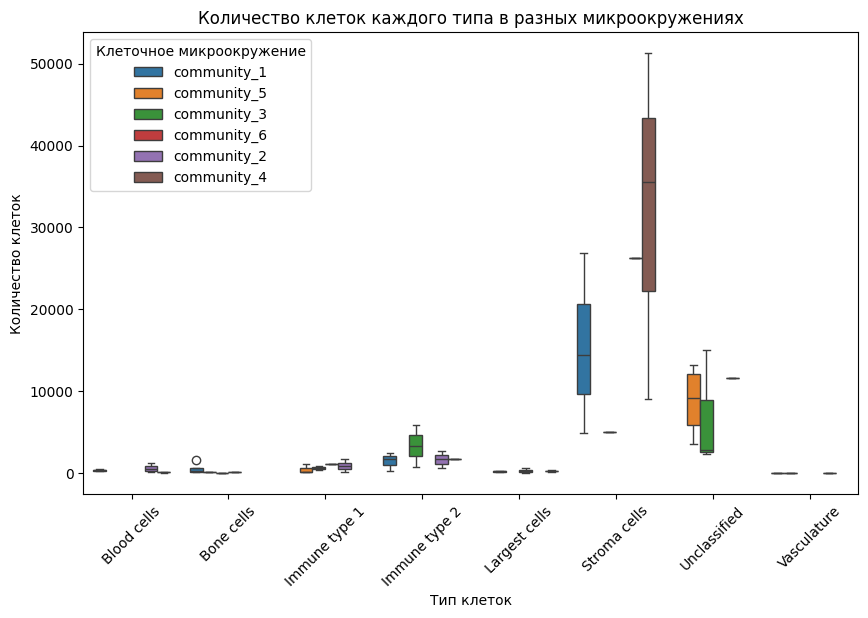

In [19]:
# создание ящичной диаграммы
plt.figure(figsize=(10, 6))
sns.boxplot(x='cell_type', y='cell_count',hue='cell_interaction', data=cell_counts)
plt.title('Количество клеток каждого типа в разных микроокружениях')
plt.xlabel('Тип клеток')
plt.ylabel('Количество клеток')
plt.xticks(rotation=45)
plt.legend(title='Клеточное микроокружение')
plt.show()

In [20]:
# группировка данных по пациентам
grouped_data = data.groupby('case_id')

# создание списков для хранения результатов
case_ids = []
interactions = []
cell_counts = []
proportions = []

# итерация по каждому пациенту
for case_id, group in grouped_data:
    # подсчет общего количества клеток в ткани пациента
    total_cells = group.shape[0]

    # группировка данных по типу микроокружения
    interaction_groups = group.groupby('cell_interaction')

    # итерация по каждому типу микроокружения
    for interaction, interaction_group in interaction_groups:
        # подсчет количества клеток, принадлежащих к этому микроокружению
        cell_count = interaction_group.shape[0]

        # рассчет доли каждого микроокружения
        proportion = cell_count / total_cells

        # добавление результатов в списки
        case_ids.append(case_id)
        interactions.append(interaction)
        cell_counts.append(cell_count)
        proportions.append(proportion)

# создание DataFrame из списков
result = pd.DataFrame({'case_id': case_ids, 'cell_interaction': interactions,
                       'cell_count': cell_counts, 'proportion': proportions})

# добавление других колонок из исходного датасета
result = pd.merge(result, data.drop_duplicates(
    'case_id'), on='case_id', how='left')

# добавление столбца 'cell_interaction' из result
result['cell_interaction'] = interactions
print(result)

    case_id cell_interaction_x  cell_count  proportion  \
0        40        community_1        7421    0.148236   
1        40        community_2        7734    0.154488   
2        40        community_3        8252    0.164836   
3        40        community_4        3669    0.073289   
4        40        community_5       13664    0.272942   
5        40        community_6        9322    0.186209   
6       199        community_1        8318    0.189952   
7       199        community_2       10530    0.240466   
8       199        community_3        5593    0.127723   
9       199        community_4        7626    0.174149   
10      199        community_5        7074    0.161544   
11      199        community_6        4649    0.106166   
12      559        community_1        1670    0.210779   
13      559        community_2        1389    0.175312   
14      559        community_3        1332    0.168118   
15      559        community_4         947    0.119525   
16      559   

In [21]:
# группировка данных по типу клетки и типу микроокружения
grouped_data = result.groupby(['cell_type', 'cell_interaction'])

# создание пустого словаря для хранения результатов сравнения
comparison_results = {}

# итерация по каждой группе
for (cell_type, cell_interaction), group in grouped_data:
    # Находим максимальное количество клеток для данного типа микроокружения
    max_cell_count = group['cell_count'].max()

    # проверяем, если текущее количество клеток статистически больше максимального количества
    if group['cell_count'].iloc[0] == max_cell_count:
        comparison_results[cell_type] = cell_interaction

# вывод результата сравнения
for cell_type, cell_interaction in comparison_results.items():
    print(f"Тип клетки '{cell_type}' статистически больше всего в микроокружении '{cell_interaction}'")

Тип клетки 'Largest cells' статистически больше всего в микроокружении 'community_6'
Тип клетки 'Stroma cells' статистически больше всего в микроокружении 'community_6'
Тип клетки 'Unclassified' статистически больше всего в микроокружении 'community_6'


In [22]:
# группировка данных по типу клетки и типу микроокружения
grouped_data = result.groupby(['cell_type', 'cell_interaction'])

# итерация по каждой группе
for (cell_type, cell_interaction), group in grouped_data:
    # проверяем, если количество наблюдений меньше или равно трем
    if len(group) <= 3:
        # выводим информацию о группе на экран
        print(f"Тип клетки '{cell_type}', микроокружение '{cell_interaction}', количество наблюдений: {len(group)}")

Тип клетки 'Largest cells', микроокружение 'community_1', количество наблюдений: 1
Тип клетки 'Largest cells', микроокружение 'community_2', количество наблюдений: 1
Тип клетки 'Largest cells', микроокружение 'community_3', количество наблюдений: 1
Тип клетки 'Largest cells', микроокружение 'community_4', количество наблюдений: 1
Тип клетки 'Largest cells', микроокружение 'community_5', количество наблюдений: 1
Тип клетки 'Largest cells', микроокружение 'community_6', количество наблюдений: 1
Тип клетки 'Unclassified', микроокружение 'community_1', количество наблюдений: 1
Тип клетки 'Unclassified', микроокружение 'community_2', количество наблюдений: 1
Тип клетки 'Unclassified', микроокружение 'community_3', количество наблюдений: 1
Тип клетки 'Unclassified', микроокружение 'community_4', количество наблюдений: 1
Тип клетки 'Unclassified', микроокружение 'community_5', количество наблюдений: 1
Тип клетки 'Unclassified', микроокружение 'community_6', количество наблюдений: 1


при разбиении сформировалось много мельких групп, для которых статистика не применима, их убираем.

In [23]:
# Создание списка для хранения результатов теста Шапиро-Уилка
shapiro_results = []

# Группировка данных по типу клетки и типу микроокружения
grouped_data = result.groupby(['cell_type', 'cell_interaction'])

# Итерация по каждой группе
for (cell_type, cell_interaction), group in grouped_data:
    # Исключаем группы, где количество наблюдений меньше или равно 3
    if len(group) > 3:
        # Выполнение теста Шапиро-Уилка на нормальность распределения
        stat, p_value = shapiro(group['cell_count'])

        # Добавление результатов теста в список
        shapiro_results.append({'cell_type': cell_type, 'cell_interaction': cell_interaction,
                                'statistic': stat, 'p_value': p_value})

# Создание DataFrame из результатов теста
shapiro_df = pd.DataFrame(shapiro_results)

# Вывод результатов теста
print(shapiro_df)

      cell_type cell_interaction  statistic   p_value
0  Stroma cells      community_1   0.920763  0.510873
1  Stroma cells      community_2   0.828604  0.104598
2  Stroma cells      community_3   0.836114  0.121012
3  Stroma cells      community_4   0.816570  0.082404
4  Stroma cells      community_5   0.794109  0.051987
5  Stroma cells      community_6   0.844868  0.142974


распределение не является нормальным, далее применяем критерий Краскела-Уолиса.

In [24]:
from scipy.stats import kruskal

# Группировка данных по типу клетки и типу микроокружения
grouped_data = result.groupby(['cell_type', 'cell_interaction'])

# Создание списка для хранения результатов теста Краскела-Уоллиса
kruskal_results = []

# Итерация по каждой группе
for (cell_type, cell_interaction), group in grouped_data:
    # Проверяем, если количество наблюдений больше трех, был пройден тест Шапиро-Уилка
    # и в группе есть как минимум два уникальных типа клеток
    if len(group) > 3 and len(group['cell_type'].unique()) > 1:
        # Применение теста Краскела-Уоллиса к данным группы
        stat, p_value = kruskal(
            *[group[group['cell_type'] == t]['cell_count'].values for t in group['cell_type'].unique()])

        # Добавление результатов теста в список
        kruskal_results.append({'cell_type': cell_type, 'cell_interaction': cell_interaction,
                                'statistic': stat, 'p_value': p_value})

# Создание DataFrame из результатов теста
kruskal_df = pd.DataFrame(kruskal_results)

# Вывод результатов теста
print(kruskal_df)

Empty DataFrame
Columns: []
Index: []


Вывод. Тест Коаскела-Уолиса не удается применить. Тип клетки 'Largest cells' 'Stroma cells' 'Unclassified' статистически больше всего в микроокружении 'community_6' при подсчете наблюдений в группах после группировки данных по типу клеток и типу микроокружения. При визуальной оценке рафика "ящик с усами", до применения различных группировок данных в 'Stroma cells' преобладает микроокружение 1 и 4, в 'Unclassified' - микроокружение  5 и 3.

### задача 3
 Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:  по Ох будут микроокружения, по Оу — их доля в ткани пациента. Не забудьте посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.

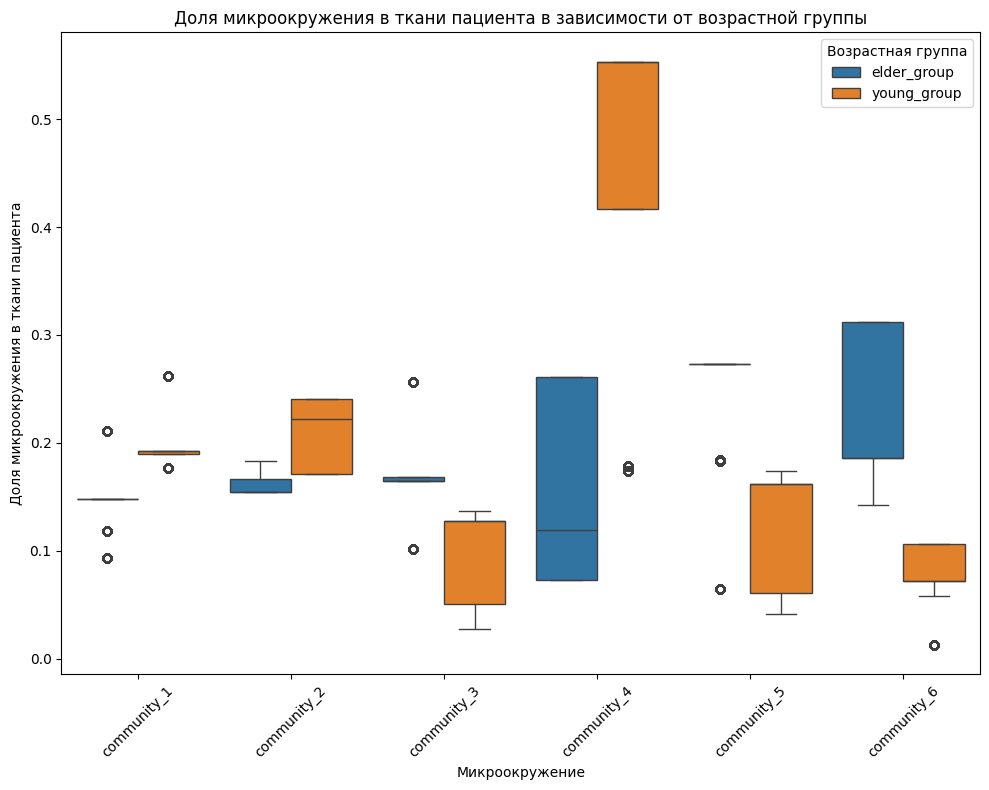

In [25]:
# Рассчитываем долю каждого микроокружения в ткани каждого пациента
data['microenvironment_proportion'] = data.groupby(['case_id', 'cell_interaction'])[
    'cell_interaction'].transform('count') / data.groupby('case_id')['cell_interaction'].transform('count')

# Создаем ящичную диаграмму
plt.figure(figsize=(10, 8))
sns.boxplot(x='cell_interaction', y='microenvironment_proportion',
            hue='age_group', data=data)
plt.title('Доля микроокружения в ткани пациента в зависимости от возрастной группы')
plt.xlabel('Микроокружение')
plt.ylabel('Доля микроокружения в ткани пациента')
# Возможно, вам захочется повернуть метки по оси x для лучшей читаемости
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')
plt.tight_layout()
plt.show()

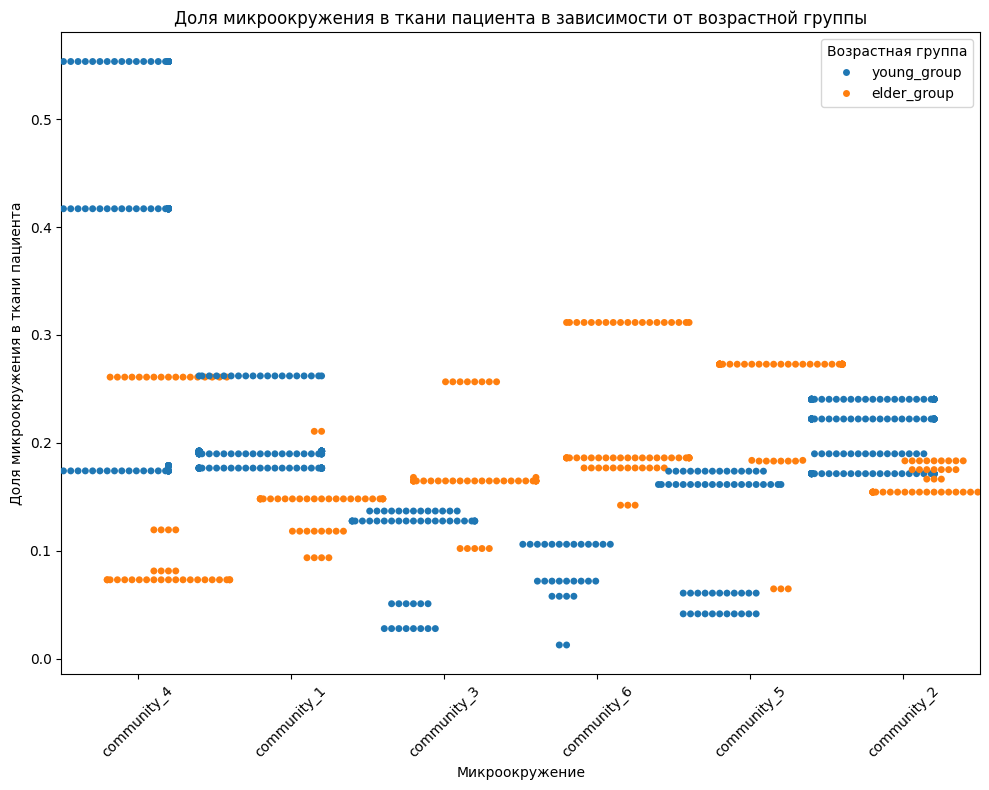

In [26]:
# Рассчитываем долю каждого микроокружения в ткани каждого пациента
data['microenvironment_proportion'] = data.groupby(['case_id', 'cell_interaction'])[
    'cell_interaction'].transform('count') / data.groupby('case_id')['cell_interaction'].transform('count')

# Взять случайное подмножество данных (1000 наблюдений)
# укажите количество наблюдений для построения графика
data_subset = data.sample(n=1000, random_state=42)

# Создаем полосчатую диаграмму (swarmplot) с подмножеством данных
plt.figure(figsize=(10, 8))
sns.swarmplot(x='cell_interaction', y='microenvironment_proportion',
              hue='age_group', data=data_subset, dodge=True)
plt.title('Доля микроокружения в ткани пациента в зависимости от возрастной группы')
plt.xlabel('Микроокружение')
plt.ylabel('Доля микроокружения в ткани пациента')
# Возможно, вам захочется повернуть метки по оси x для лучшей читаемости
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')
plt.tight_layout()
plt.show()

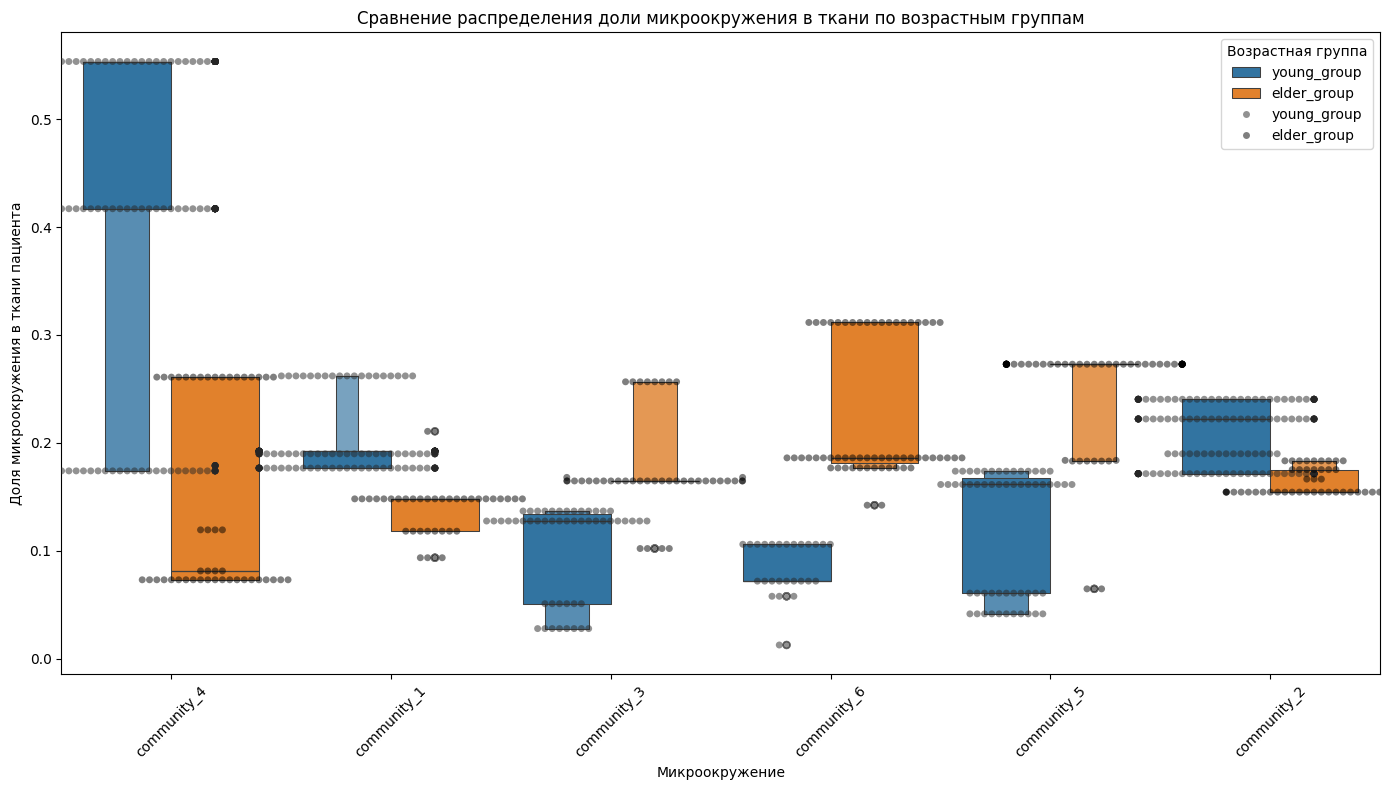

In [27]:
# Рассчитываем долю каждого микроокружения в ткани каждого пациента
data['microenvironment_proportion'] = data.groupby(['case_id', 'cell_interaction'])[
    'cell_interaction'].transform('count') / data.groupby('case_id')['cell_interaction'].transform('count')

# Взять случайное подмножество данных (1000 наблюдений)
# укажите количество наблюдений для построения графика
data_subset = data.sample(n=1000, random_state=42)

# Создаем catplot с boxen plot
plt.figure(figsize=(14, 8))
sns.boxenplot(x='cell_interaction', y='microenvironment_proportion',
              hue='age_group', data=data_subset, dodge=True)
sns.swarmplot(x='cell_interaction', y='microenvironment_proportion',
              hue='age_group', data=data_subset, dodge=True, color='k', alpha=0.5)
plt.title('Сравнение распределения доли микроокружения в ткани по возрастным группам')
plt.xlabel('Микроокружение')
plt.ylabel('Доля микроокружения в ткани пациента')
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')
plt.tight_layout()
plt.show()

На основании визуальной оценки данных можно сказать, что доля микроокружения 4,1 и 2 выше в тканях пожилых пациентов. Доля микроокружения 3, 6 и 5 - выше в тканях пожилых пациентов.

#### задача 4
Правда ли, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

In [28]:
# разделим данные на две группы: молодые и пожилые пациенты
young_patients = data[data['age_group'] == 'young_group']
old_patients = data[data['age_group'] == 'elder_group']

# отфильтруем данные для каждой группы, оставив только иммунные и стромальные клетки
young_imm_stroma = young_patients[(young_patients['cell_type'].isin(
    ['Immune type 1', 'Immune type 2', 'Stroma cells']))]
old_imm_stroma = old_patients[(old_patients['cell_type'].isin( 
    ['Immune type 1', 'Immune type 2', 'Stroma cells']))]

print(young_imm_stroma) 

        distance_to_vasculature  distance_to_largest_cell  immune_marker_1  \
315                  634.200203                983.403426        26.426694   
316                  610.444296               1000.488024        22.419208   
317                  782.995484                787.660055        36.285363   
318                  811.000834                608.351406        19.874799   
319                  704.830780                883.960378        35.305848   
...                         ...                       ...              ...   
269436               756.724495                621.686459         8.249116   
269437               928.977004                720.993469         9.667603   
269438               651.888363               1040.658354        20.298864   
269440               901.768538                700.092692        11.459289   
269441              1118.234561                901.529372        19.106614   

        immune_marker_2 cell_interaction      cell_type  case_i

In [29]:
# рассчитываем средние значения для каждого типа клеток и каждой группы
young_mean = young_imm_stroma.groupby('cell_type')[['distance_to_vasculature', 'distance_to_largest_cell']].mean()
old_mean = old_imm_stroma.groupby( 'cell_type')[['distance_to_vasculature', 'distance_to_largest_cell']].mean()

# посмотрим результат
print("Средние значения для молодых пациентов (young_imm_stroma):")
print(young_mean)

print("\nСредние значения для пожилых пациентов (old_imm_stroma):")
print(old_mean)

Средние значения для молодых пациентов (young_imm_stroma):
               distance_to_vasculature  distance_to_largest_cell
cell_type                                                       
Immune type 1               977.047778                755.677605
Immune type 2               942.134636                764.188496
Stroma cells                977.663422                768.427575

Средние значения для пожилых пациентов (old_imm_stroma):
               distance_to_vasculature  distance_to_largest_cell
cell_type                                                       
Immune type 1               817.844810                760.573066
Immune type 2               800.213120                736.503375
Stroma cells                830.807948                760.470815


In [30]:
# рассчитываем средние значения для каждого типа клеток и каждой группы
young_mean = young_imm_stroma.groupby('cell_type')['distance_to_vasculature'].mean()
old_mean = old_imm_stroma.groupby('cell_type')['distance_to_vasculature'].mean()

# Вычисляем разницу между средними значениями для каждого типа клеток между группами
difference = old_mean - young_mean

# Вывод результатов
print("Разница м/ж ср. зн. для Immune type 1, Immune type 2 и Stroma cells (distance_to_vasculature) м/ж гр. молодых и пожилых пациентов:")
print(difference)

Разница м/ж ср. зн. для Immune type 1, Immune type 2 и Stroma cells (distance_to_vasculature) м/ж гр. молодых и пожилых пациентов:
cell_type
Immune type 1   -159.202969
Immune type 2   -141.921516
Stroma cells    -146.855474
Name: distance_to_vasculature, dtype: float64


In [31]:
# Рассчитываем средние значения для каждого типа клеток и каждой группы
young_mean = young_imm_stroma.groupby(
    'cell_type')['distance_to_largest_cell'].mean()
old_mean = old_imm_stroma.groupby(
    'cell_type')['distance_to_largest_cell'].mean()

# Вычисляем разницу между средними значениями для каждого типа клеток между группами
difference = old_mean - young_mean

# Вывод результатов
print("Разница между средними значениями для Immune type 1, Immune type 2 и Stroma cells (distance_to_largest_cell) между группами молодых и пожилых пациентов:")
print(difference)

Разница между средними значениями для Immune type 1, Immune type 2 и Stroma cells (distance_to_largest_cell) между группами молодых и пожилых пациентов:
cell_type
Immune type 1     4.895462
Immune type 2   -27.685121
Stroma cells     -7.956761
Name: distance_to_largest_cell, dtype: float64


In [37]:
# Количество повторных выборок
num_samples = 2000

# Получение данных для клеток типа Immune type 1, Immune type 2 и Stroma cells для признака distance_to_vasculature из группы young_imm_stroma
data_imm_vasculature = young_imm_stroma.loc[young_imm_stroma['cell_type'].isin(
    ['Immune type 1', 'Immune type 2', 'Stroma cells']), 'distance_to_vasculature']

# Генерация 10000 повторных выборок с возвратом
bootstrap_samples1 = [np.random.choice(data_imm_vasculature, size=len(
    data_imm_vasculature), replace=True) for _ in range(num_samples)]

# Проверка размера полученного массива
print("Размер массива повторных выборок:", len(bootstrap_samples1))
print("Размер каждой повторной выборки:", len(bootstrap_samples1[0]))


# Вычисление средних значений для каждой выборки
means = [sample.mean() for sample in bootstrap_samples1]

# Вычисление разницы средних значений
mean_difference1 = np.mean(means) - data_imm_vasculature.mean()

# Вывод результатов
print("Разница средних значений между повторными выборками и исходными данными:", mean_difference1)

Размер массива повторных выборок: 2000
Размер каждой повторной выборки: 140047
Разница средних значений между повторными выборками и исходными данными: 0.027915181707271586


моему компьютеру не хватает оперативной памяти для создания массива в 10000 размера, поэтому я ограничиваюсь 2000

In [38]:
# Количество повторных выборок
num_samples = 2000

# Получение данных для клеток типа Immune type 1, Immune type 2 и Stroma cells для признака distance_to_largest_cell из группы young_imm_stroma
data_imm_largest_cell = young_imm_stroma.loc[young_imm_stroma['cell_type'].isin(
    ['Immune type 1', 'Immune type 2', 'Stroma cells']), 'distance_to_largest_cell']

# Генерация 2000 повторных выборок с возвратом
bootstrap_samples2 = [np.random.choice(data_imm_largest_cell, size=len(
    data_imm_largest_cell), replace=True) for _ in range(num_samples)]

# Проверка размера полученного массива
print("Размер массива повторных выборок:", len(bootstrap_samples2))
print("Размер каждой повторной выборки:", len(bootstrap_samples2[0]))


# Вычисление средних значений для каждой выборки
means = [sample.mean() for sample in bootstrap_samples2]

# Вычисление разницы средних значений
mean_difference2 = np.mean(means) - data_imm_largest_cell.mean()

# Вывод результатов
print("Разница средних значений между повторными выборками и исходными данными:", mean_difference2)

Размер массива повторных выборок: 2000
Размер каждой повторной выборки: 140047
Разница средних значений между повторными выборками и исходными данными: -0.005934443444630233


In [39]:
# Количество повторных выборок
num_samples = 2000

# Получение данных для клеток типа Immune type 1, Immune type 2 и Stroma cells для признака distance_to_vasculature из группы old_imm_stroma
data_imm_vasculature_old = old_imm_stroma.loc[old_imm_stroma['cell_type'].isin(
    ['Immune type 1', 'Immune type 2', 'Stroma cells']), 'distance_to_vasculature']

# Генерация 2000 повторных выборок с возвратом
bootstrap_samples_old1 = [np.random.choice(data_imm_vasculature_old, size=len(
    data_imm_vasculature_old), replace=True) for _ in range(num_samples)]

# Проверка размера полученного массива
print("Размер массива повторных выборок:", len(bootstrap_samples_old1))
print("Размер каждой повторной выборки:", len(bootstrap_samples_old1[0]))

# Вычисление средних значений для каждой выборки
means_old1 = [sample.mean() for sample in bootstrap_samples_old1]

# Вычисление среднего значения исходных данных
mean_old_imm_vasculature = data_imm_vasculature_old.mean()

# Вычисление разницы средних значений
mean_difference_old = np.mean(means_old1) - mean_old_imm_vasculature

# Вывод результатов
print("Разница средних значений между повторными выборками и исходными данными:",
      mean_difference_old)

Размер массива повторных выборок: 2000
Размер каждой повторной выборки: 54924
Разница средних значений между повторными выборками и исходными данными: -0.0037335162436420433


In [41]:
# Количество повторных выборок
num_samples = 2000

# Получение данных для клеток типа Immune type 1, Immune type 2 и Stroma cells для признака distance_to_largest_cell из группы old_imm_stroma
data_imm_largest_cell_old = old_imm_stroma.loc[old_imm_stroma['cell_type'].isin(
    ['Immune type 1', 'Immune type 2', 'Stroma cells']), 'distance_to_largest_cell']

# Генерация 2000 повторных выборок с возвратом
bootstrap_samples_old2 = [np.random.choice(data_imm_largest_cell_old, size=len(
    data_imm_largest_cell_old), replace=True) for _ in range(num_samples)]

# Проверка размера полученного массива
print("Размер массива повторных выборок:", len(bootstrap_samples_old2))
print("Размер каждой повторной выборки:", len(bootstrap_samples_old2[0]))


# Вычисление средних значений для каждой выборки
means_old = [sample.mean() for sample in bootstrap_samples_old2]

# Вычисление среднего значения исходных данных
mean_old_imm_largest_cell = data_imm_largest_cell_old.mean()

# Вычисление разницы средних значений
mean_difference_old2 = np.mean(means_old) - mean_old_imm_largest_cell

# Вывод результатов
print("Разница средних значений между повторными выборками и исходными данными:",
      mean_difference_old2)

Размер массива повторных выборок: 2000
Размер каждой повторной выборки: 54924
Разница средних значений между повторными выборками и исходными данными: -0.017668486484467394


In [42]:
# Получение разницы средних значений для каждой выборки
mean_differences = []

for sample in bootstrap_samples1:
    mean_difference = sample.mean() - data_imm_vasculature.mean()
    mean_differences.append(mean_difference)

# Вычисление доверительного интервала для первой разницы средних
confidence_interval1 = np.percentile(mean_differences, [2.5, 97.5])

# Аналогично для второй разницы средних
mean_differences = []

for sample in bootstrap_samples2:
    mean_difference = sample.mean() - data_imm_largest_cell.mean()
    mean_differences.append(mean_difference)

# Вычисление доверительного интервала для второй разницы средних
confidence_interval2 = np.percentile(mean_differences, [2.5, 97.5])

print("Доверительный интервал для разницы средних (bootstrap_samples1):",
      confidence_interval1)
print("Доверительный интервал для разницы средних (bootstrap_samples2):",
      confidence_interval2)

Доверительный интервал для разницы средних (bootstrap_samples1): [-1.14465031  1.30173536]
Доверительный интервал для разницы средних (bootstrap_samples2): [-0.670684    0.69181091]


In [43]:
# Получение разницы средних значений для первой выборки
mean_differences_old1 = []

for sample in bootstrap_samples_old1:
    mean_difference_old = sample.mean() - mean_old_imm_vasculature
    mean_differences_old1.append(mean_difference_old)

# Вычисление доверительного интервала для первой разницы средних
confidence_interval_old1 = np.percentile(mean_differences_old1, [2.5, 97.5])

# Аналогично для второй выборки
mean_differences_old2 = []

for sample in bootstrap_samples_old2:
    mean_difference_old2 = sample.mean() - mean_old_imm_largest_cell
    mean_differences_old2.append(mean_difference_old2)

# Вычисление доверительного интервала для второй разницы средних
confidence_interval_old2 = np.percentile(mean_differences_old2, [2.5, 97.5])

print("Доверительный интервал для разницы средних (bootstrap_samples_old1):",
      confidence_interval_old1)
print("Доверительный интервал для разницы средних (bootstrap_samples_old2):",
      confidence_interval_old2)

Доверительный интервал для разницы средних (bootstrap_samples_old1): [-1.47583241  1.54547437]
Доверительный интервал для разницы средних (bootstrap_samples_old2): [-1.28974808  1.2982665 ]


Вывод: доверительный интервал содержит нуль, во всех случаях. Это может означать, что разница средних не является статистически значимой. Мы не можем сказать, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов